<a href="https://colab.research.google.com/github/asmital/Capsule-Networks/blob/master/Copy_of_capsnet_with_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Compatibility

The following 2 cells work for Jupyter notebook environments.

In [1]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 3.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
#Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!nvidia-smi

Sun Jun 21 10:19:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [5]:
import keras
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

Using TensorFlow backend.


2.2.4
1.15.2


In [6]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import keras.backend as K
from keras import callbacks
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.utils.data_utils import get_file
from keras import initializers, layers, models
from tensorflow.keras import backend

import matplotlib.pyplot as plt


import warnings 
warnings.filterwarnings('ignore')

# Layers in CapsNet

In [7]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

class Mask(layers.Layer):
    """
    Mask a Tensor with shape=[None, d1, d2] by the max value in axis=1.
    Output shape: [None, d2]
    """
    def call(self, inputs, **kwargs):
        # use true label to select target capsule, shape=[batch_size, num_capsule]
        if type(inputs) is list:  # true label is provided with shape = [batch_size, n_classes], i.e. one-hot code.
            assert len(inputs) == 2
            inputs, mask = inputs
        else:  # if no true label, mask by the max length of vectors of capsules
            x = inputs
            # Enlarge the range of values in x to make max(new_x)=1 and others < 0
            x = (x - K.max(x, 1, True)) / K.epsilon() + 1
            mask = K.clip(x, 0, 1)  # the max value in x clipped to 1 and other to 0

        # masked inputs, shape = [batch_size, dim_vector]
        inputs_masked = K.batch_dot(inputs, mask, [1, 1])
        return inputs_masked

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:  # true label provided
            return tuple([None, input_shape[0][-1]])
        else:
            return tuple([None, input_shape[-1]])


def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (0.5 + s_squared_norm) / K.sqrt(s_squared_norm)
    return scale * vectors


class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self, input_shape):
        assert len(input_shape) >= 3, "The input Tensor should have shape=[None, input_num_capsule, input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        # Transformation matrix/Weight matrix
        self.W = self.add_weight(shape=[self.input_num_capsule, self.num_capsule, self.input_dim_vector, self.dim_vector],
                                 initializer=self.kernel_initializer,
                                 name='W')

        # Coupling coefficient. The redundant dimensions are just to facilitate subsequent matrix calculation.
        self.bias = self.add_weight(shape=[1, self.input_num_capsule, self.num_capsule, 1, 1],
                                    initializer=self.bias_initializer,
                                    name='bias',
                                    trainable=False)
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate(tile) num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        
        # inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))

        # DYNAMIC ROUTING
        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # update the raw weights for the next routing iteration
                # by adding the agreement to the previous raw weights
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])


def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

**Define the key layers required to build any capsnet architecture**

# Build the network

**Build the required capsnet architecture using the layers defined above**

In [48]:
def CapsNet(input_shape, n_class, num_routing, digit_caps_dim_vector=16):
    """
    A Capsule Network on MNIST.
    :param input_shape: data shape, 4d, [None, width, height, channels]
    :param n_class: number of classes
    :param num_routing: number of routing iterations
    :return: A Keras Model with 2 inputs and 2 outputs
    """
    x = layers.Input(shape=input_shape)

    # Layer 1: Conventional Conv2D layer
    conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)
    conv1 = layers.BatchNormalization(name='batch_norm1')(conv1)

    # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_vector]
    primarycaps = PrimaryCap(conv1, dim_vector=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

    # Layer 3: Capsule layer. Dynamic Routing algorithm works here.
    digitcaps = CapsuleLayer(num_capsule=n_class, dim_vector=digit_caps_dim_vector, num_routing=num_routing, name='digit_caps')(primarycaps)

    # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
    out_caps = Length(name='out_caps')(digitcaps)

    y = layers.Input(shape=(n_class,))
    masked = Mask()([digitcaps, y])  # The true label is used to mask the output of capsule layer.

    
    f=2*2
    outputmodel =layers.Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu', name='outputmodel')(x)
    outputmodel=layers.BatchNormalization(momentum=0.5, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)
    outputmodel=layers.Conv2D(64,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.1, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.MaxPooling2D(2,2)(outputmodel)
    outputmodel=layers.Dropout(0.2)(outputmodel)

    outputmodel=layers.Conv2D(128,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.2, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.Conv2D(128,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.1, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.MaxPooling2D(2,2)(outputmodel)
    outputmodel=layers.Dropout(0.2)(outputmodel)

    outputmodel=layers.Conv2D(256,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.2, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)
  
    outputmodel=layers.Conv2D(256,(3,3), padding='same')(outputmodel)
    outputmodel=layers.BatchNormalization(momentum=0.1, epsilon=1e-5,gamma_initializer="uniform")(outputmodel)
    outputmodel =layers.LeakyReLU(alpha=0.1)(outputmodel)
  
    outputmodel=layers.MaxPooling2D(2,2)(outputmodel)
    outputmodel=layers.Dropout(0.2)(outputmodel)
    
    outputmodel=layers.Flatten()(outputmodel)
    outputmodel=layers.Dense(256)(outputmodel)
    outputmodel=layers.LeakyReLU(alpha=0.1)(outputmodel)

    outputmodel=layers.BatchNormalization()(outputmodel)
    outputmodel=layers.Dense(10, activation='softmax')(outputmodel)
    
        
    decoder = models.Sequential(name='decoder')
    decoder.add(layers.Dense(input_dim=digit_caps_dim_vector, activation="relu", output_dim=7*7*digit_caps_dim_vector, name='dense1'))
    decoder.add(layers.Reshape((7, 7, digit_caps_dim_vector)))
    decoder.add(layers.BatchNormalization(name='batch_norm2'))
    decoder.add(layers.Deconvolution2D(64, 3, 3, subsample=(1, 1), border_mode='same', name='deconv1'))
    decoder.add(layers.Deconvolution2D(32, 3, 3, subsample=(2, 2), border_mode='same', name='deconv2'))
    decoder.add(layers.Deconvolution2D(16, 3, 3, subsample=(2, 2), border_mode='same', name='deconv3'))
    decoder.add(layers.Deconvolution2D(1, 3, 3, subsample=(1, 1), border_mode='same', name='deconv4'))
    decoder.add(layers.Activation("relu"))
    decoder.add(layers.Reshape(target_shape=input_shape, name='out_recon'))

    # plot the decoder/reconstruction network
    #try:
      #plot_model(decoder, to_file='decoder.png', show_shapes=True)
    #except Exception as e:
      #print('No fancy plot {}'.format(e))

    # create model used for training/inference/prediction
    # two-input-two-output keras Model
    train_model = models.Model(inputs=[x, y], outputs=[outputmodel, decoder(masked)])
    return train_model

    # create model to manipulate fed digit to visualise the effect of a caps dimension on the reconstruction
    # three-input-one-output keras Model; input: (image, mask, noise)
    #noise = layers.Input(shape=(n_class, digit_caps_dim_vector))
    #noise_plus_digitcaps = layers.Add()([digitcaps, noise])
    #masked_noised_y = Mask()([noise_plus_digitcaps, y]) # masked the noised digitcaps with input
    #manip_model = models.Model([x, y, noise], decoder(masked_noised_y))

    #return train_model, manip_model

# Margin Loss

**Use custom margin loss as proposed in the original paper for gradient updates**

In [9]:
def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

# Load Data

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import gzip


def load_data():
    """Loads the Kannada-MNIST dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = os.path.join('datasets', 'Kannada-mnist')
    base = 'https://github.com/vinayprabhu/Kannada_MNIST/blob/master/data/output_tensors/MNIST_format/'
    files = ['y_kannada_MNIST_train-idx1-ubyte.gz', 'X_kannada_MNIST_train-idx3-ubyte.gz',
             'y_kannada_MNIST_test-idx1-ubyte.gz', 'X_kannada_MNIST_test-idx3-ubyte.gz',
             'y_dig_MNIST-idx1-ubyte.gz', 'X_dig_MNIST-idx3-ubyte.gz']

    paths = []
    for fname in files:
        paths.append(get_file(fname,
                              origin=base + fname+'?raw=true',
                              cache_subdir=dirname))

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8,
                                offset=16).reshape(len(y_train), 28, 28)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8,
                               offset=16).reshape(len(y_test), 28, 28)
    
    with gzip.open(paths[2], 'rb') as lbpath:
        y_dig = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[5], 'rb') as imgpath:
        x_dig = np.frombuffer(imgpath.read(), np.uint8,
                               offset=16).reshape(10240, 28, 28)                               

    return (x_train, y_train), (x_test, y_test), (x_dig, y_dig)


In [11]:
(train_images, train_labels), (test_images, test_labels), (dig_images, dig_labels) = load_data()
print(f'Training set images: {train_images.shape}')
print(f'Testing set images: {test_images.shape}')
print(f'DIG-10K set images: {dig_images.shape}')

6922240/6918402 [==============================] - 0s 0us/step
8192/103 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

**Normalise the image data and one-hot encode the targets/labels**

In [12]:
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.
dig_images = dig_images.reshape((-1, 28, 28, 1)).astype('float32') / 255.

train_labels = to_categorical(train_labels.astype('float32'))
test_labels = to_categorical(test_labels.astype('float32'))
dig_labels = to_categorical(dig_labels.astype('float32'))

**Train-Validation spilt(90%-10%)**

In [13]:
val_images = train_images[54000:]
val_labels = train_labels[54000:]

train_images = train_images[:54000]
train_labels = train_labels[:54000]

In [14]:
print("Training images: ", train_images.shape)
# print(type(train_images))

print("Validation images: ", val_images.shape)
# print(type(val_images))

print("Testing images: ", test_images.shape)
# print(type(test_images))

print("DIG-10K: ", dig_images.shape)
# print(type(dig_images))

# Aliasing for conventions
x_train = train_images
y_train = train_labels

x_val = val_images
y_val = val_labels

x_test = test_images
y_test = test_labels

x_dig = dig_images
y_dig = dig_labels

Training images:  (54000, 28, 28, 1)
Validation images:  (6000, 28, 28, 1)
Testing images:  (10000, 28, 28, 1)
DIG-10K:  (10240, 28, 28, 1)


**Visualise a few samples from each of the datasets**

In [15]:
# custom util function for visualisation of the input images
def input_viz(data, title, num_row=5, num_col=10, facecolor='xkcd:ecru'):
  x, y = data
  num = num_row*num_col
  images = x[:num]
  labels = y[:num]
  
  fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row), facecolor=facecolor)
  fig.suptitle(title, fontsize=18, fontweight='bold')
  for i in range(num):
      ax = axes[i//num_col, i%num_col]
      ax.imshow(images[i].reshape((28, 28)), cmap='gray')
      ax.set_title(f'Number: {np.argmax(labels[i])}', fontsize=12)
      ax.axis('Off')
  plt.tight_layout(pad=2.0)
  plt.show()

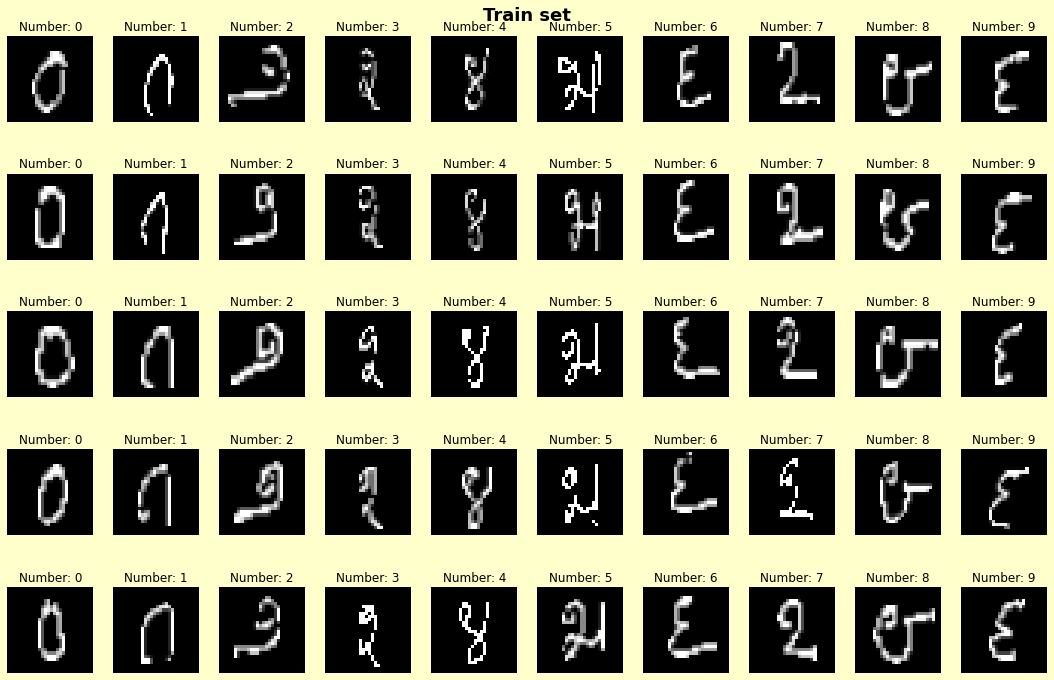

In [16]:
input_viz((x_train, y_train), 'Train set')

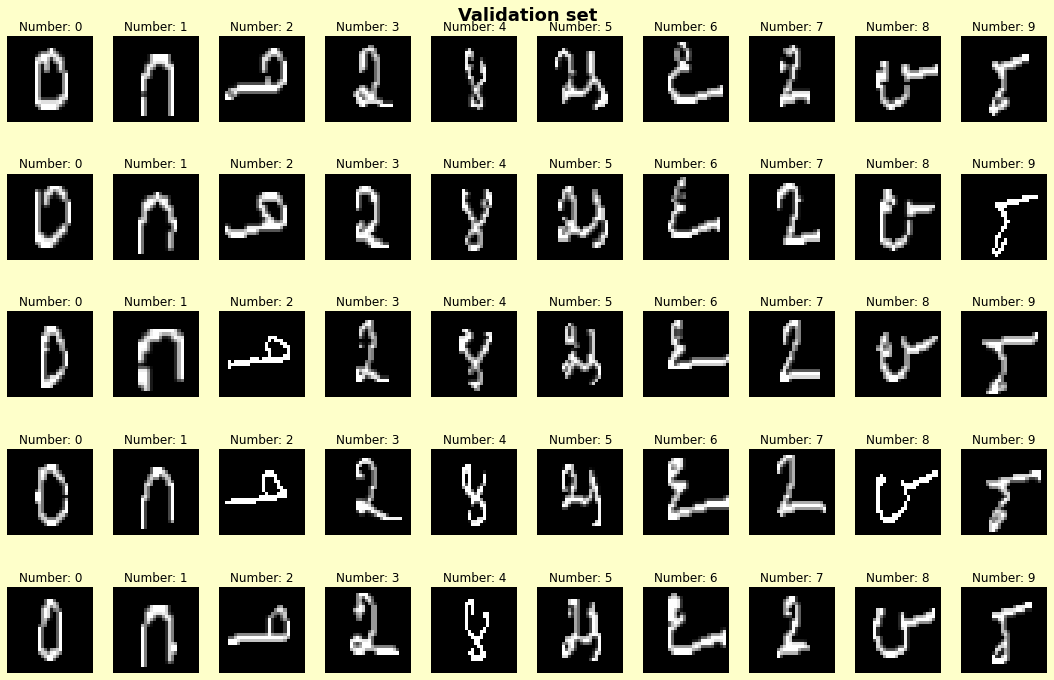

In [17]:
input_viz((x_val, y_val), 'Validation set')

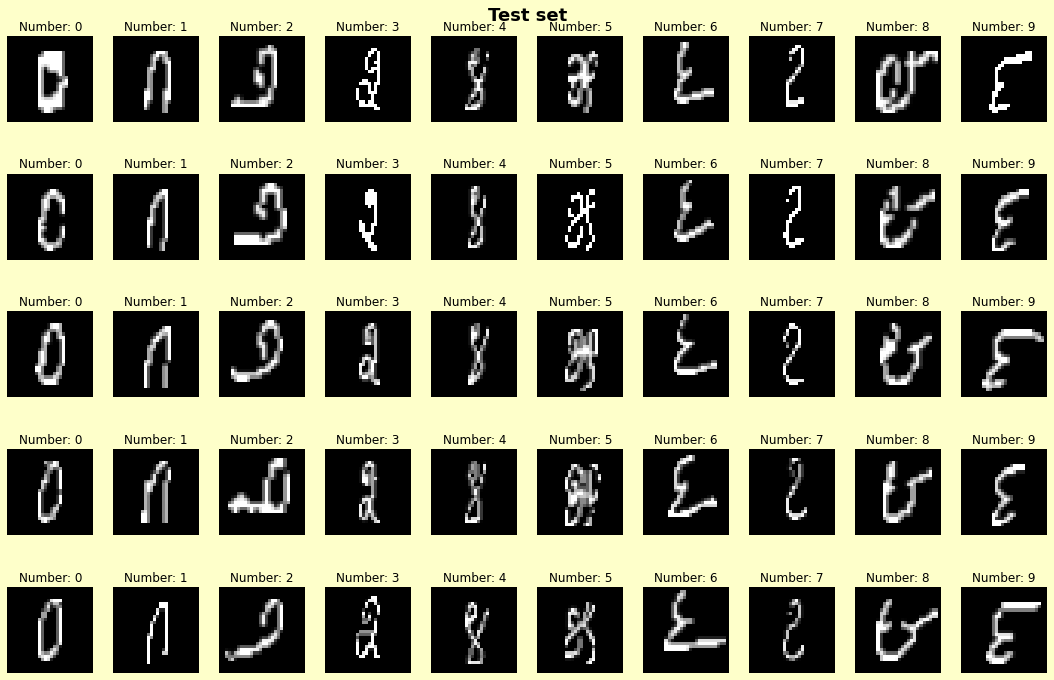

In [18]:
input_viz((x_test, y_test), 'Test set')

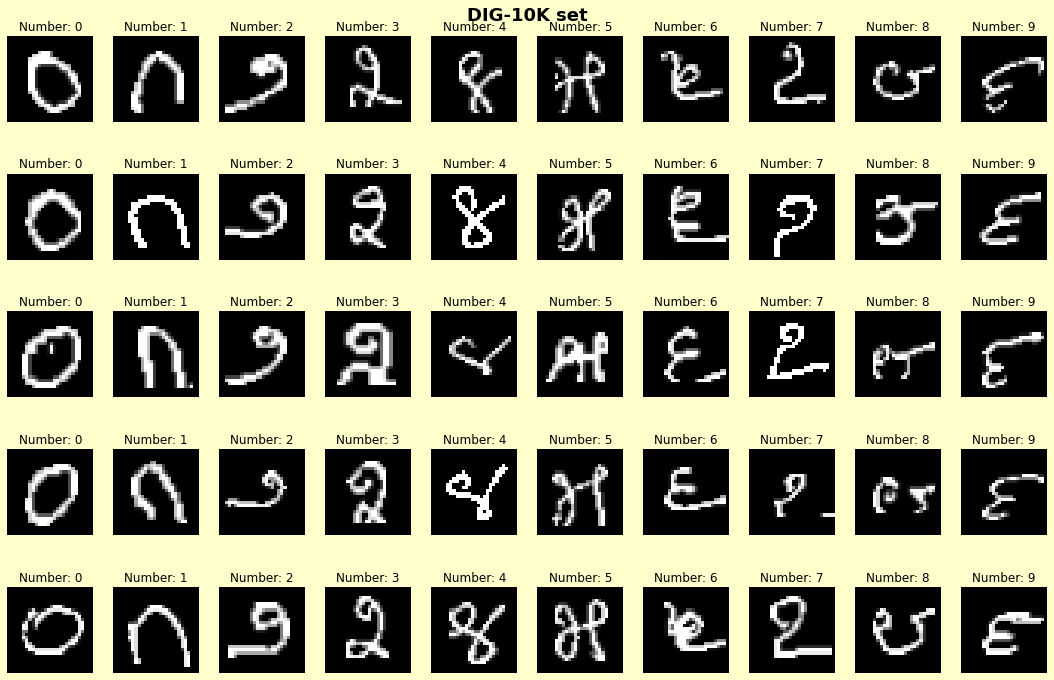

In [19]:
input_viz((x_dig, y_dig), 'DIG-10K set')

# Instantiate the model

**Define the hyperparameters**

In [51]:
class args:
  routings = 3 # number of iterations of the dynamic routing algorithm between 2 capsule layers
  digit_caps_dim_vector = 32 # number of capsules in the "digit-caps" layer OR the dimensionality of the output vectors of the digit caps layer
  batch_size = 128
  epochs = 50
  recon_loss_weight = 0.0005
  lr = 0.001

In [49]:
input_shape = x_train.shape[1:] # for kannada mnist, mnist: (28, 28, 1)
num_classes = len(np.unique(np.argmax(y_train, 1))) # for kannada mnist, mnist: 10

# define model
model = CapsNet(input_shape=input_shape,
                             n_class=num_classes,
                             num_routing=args.routings,
                             digit_caps_dim_vector=args.digit_caps_dim_vector)
model.summary()

try:
    plot_model(model, to_file='model.png', show_shapes=True)
except Exception as e:
    print('No fancy plot {}'.format(e))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
outputmodel (Conv2D)            (None, 28, 28, 64)   640         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 28, 28, 64)   256         outputmodel[0][0]                
__________________________________________________________________________________________________
leaky_re_lu_13 (LeakyReLU)      (None, 28, 28, 64)   0           batch_normalization_13[0][0]     
__________________________________________________________________________________________________
conv2d_30 

# Train the network

In [50]:
"""
the original research paper proposes using a SSE loss with a weight of 0.0005
that is equivalent to using the mean loss (MSE) and then multiply it by the total
values being output in the final layer
(sum = number of instances * mean)
"""
recon_lambda = args.recon_loss_weight*np.prod(input_shape)

In [52]:
from keras.preprocessing.image import ImageDataGenerator

def train(model, data):
    """
    Training a CapsuleNet
    :param model: the CapsuleNet model
    :param data: a tuple containing training and testing data, like `((x_train, y_train), (x_test, y_test))`
    :param args: arguments
    :return: The trained model
    """
    # unpacking the data
    (x_train, y_train), (x_val, y_val) = data

    # callbacks
    log = callbacks.CSVLogger('log.csv')
    checkpoint = callbacks.ModelCheckpoint('weights-{epoch:02d}.h5', save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: args.lr * np.exp(-epoch / 10.))

    # compile the model
    opt = 'nadam'
    model.compile(optimizer=opt,
                  loss=[margin_loss, 'mse'], # use MSE loss metric for the reconstruction network
                  loss_weights=[1., recon_lambda],
                  metrics={'out_caps': 'accuracy'})

    # Training without data augmentation:
    # history = model.fit([x_train, y_train], [y_train, x_train], batch_size=args.batch_size, epochs=args.epochs,
    #           validation_data=[[x_val, y_val], [y_val, x_val]], callbacks=[lr_decay, checkpoint, log])

    # Begin: Training with data augmentation ---------------------------------------------------------------------#
    def train_generator(x, y, batch_size, shift_fraction=0.2):
        train_datagen = ImageDataGenerator(width_shift_range=shift_fraction,
                                           height_shift_range=shift_fraction,  # shift up to 2 pixel for MNIST
                                           zca_whitening=True,
                                           rotation_range=20,
                                           zoom_range=0.2,
                                           shear_range=0.2)
        generator = train_datagen.flow(x, y, batch_size=args.batch_size)
        while 1:
            x_batch, y_batch = generator.next()
            yield ([x_batch, y_batch], [y_batch, x_batch])

    # Training with data augmentation. If shift_fraction=0., also no augmentation.
    model.fit_generator(generator=train_generator(x_train, y_train, args.batch_size, 0.2),
                        steps_per_epoch=int(y_train.shape[0]/args.batch_size),
                        epochs=args.epochs,
                        validation_data=[[x_val, y_val], [y_val, x_val]], callbacks=[lr_decay, checkpoint, log])
    # End: Training with data augmentation -----------------------------------------------------------------------#

    model.save_weights('trained_model.h5')
    print('Trained model saved to \'trained_model.h5\'')

    return model

In [53]:
train(model=model, data=((x_train, y_train), (x_val, y_val)))

Epoch 1/50
421/421 [==============================] - 166s 395ms/step - loss: 0.0700 - dense_8_loss: 0.0633 - decoder_loss: 0.0171 - val_loss: 0.0129 - val_dense_8_loss: 0.0053 - val_decoder_loss: 0.0193

Epoch 00001: val_loss improved from inf to 0.01286, saving model to weights-01.h5
Epoch 2/50
421/421 [==============================] - 157s 373ms/step - loss: 0.0228 - dense_8_loss: 0.0184 - decoder_loss: 0.0112 - val_loss: 0.0121 - val_dense_8_loss: 0.0055 - val_decoder_loss: 0.0169

Epoch 00002: val_loss improved from 0.01286 to 0.01213, saving model to weights-02.h5
Epoch 3/50
421/421 [==============================] - 157s 373ms/step - loss: 0.0180 - dense_8_loss: 0.0142 - decoder_loss: 0.0098 - val_loss: 0.0134 - val_dense_8_loss: 0.0072 - val_decoder_loss: 0.0158

Epoch 00003: val_loss did not improve from 0.01213
Epoch 4/50
421/421 [==============================] - 157s 372ms/step - loss: 0.0157 - dense_8_loss: 0.0121 - decoder_loss: 0.0091 - val_loss: 0.0102 - val_dense_8_lo

# Inference: Evaluate model performance

**Load the best weights**

**Final Weights(trained model) for this training process**

In [54]:
model.load_weights('trained_model.h5')

In [55]:
from google.colab import files
files.download("log.csv")

In [56]:
 y_pred, x_recon = model.predict([x_test, y_test], batch_size=args.batch_size)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

Test acc: 0.9872


In [57]:
dig_pred, dig_recon = model.predict([x_dig[:10000], y_dig[:10000]], batch_size=args.batch_size)
print('Dig acc:', np.sum(np.argmax(dig_pred, 1) == np.argmax(y_dig, 1)) / y_dig.shape[0])

Dig acc: 0.906


**The same model trained for 50 epochs does better on both the test sets, the model probably overfit on training for than 50 epochs**

In [ ]:
#model.load_weights('best.h5')

In [ ]:
#y_pred, x_recon = model.predict([x_test, y_test], batch_size=args.batch_size)
#print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])

In [ ]:
#dig_pred, dig_recon = model.predict([x_dig[:10000], y_dig[:10000]], batch_size=args.batch_size)
#print('Dig acc:', np.sum(np.argmax(dig_pred, 1) == np.argmax(y_dig, 1)) / y_dig.shape[0])

# Visualisation

**Visualise the model architecture in use**

Encoder/Capsule network

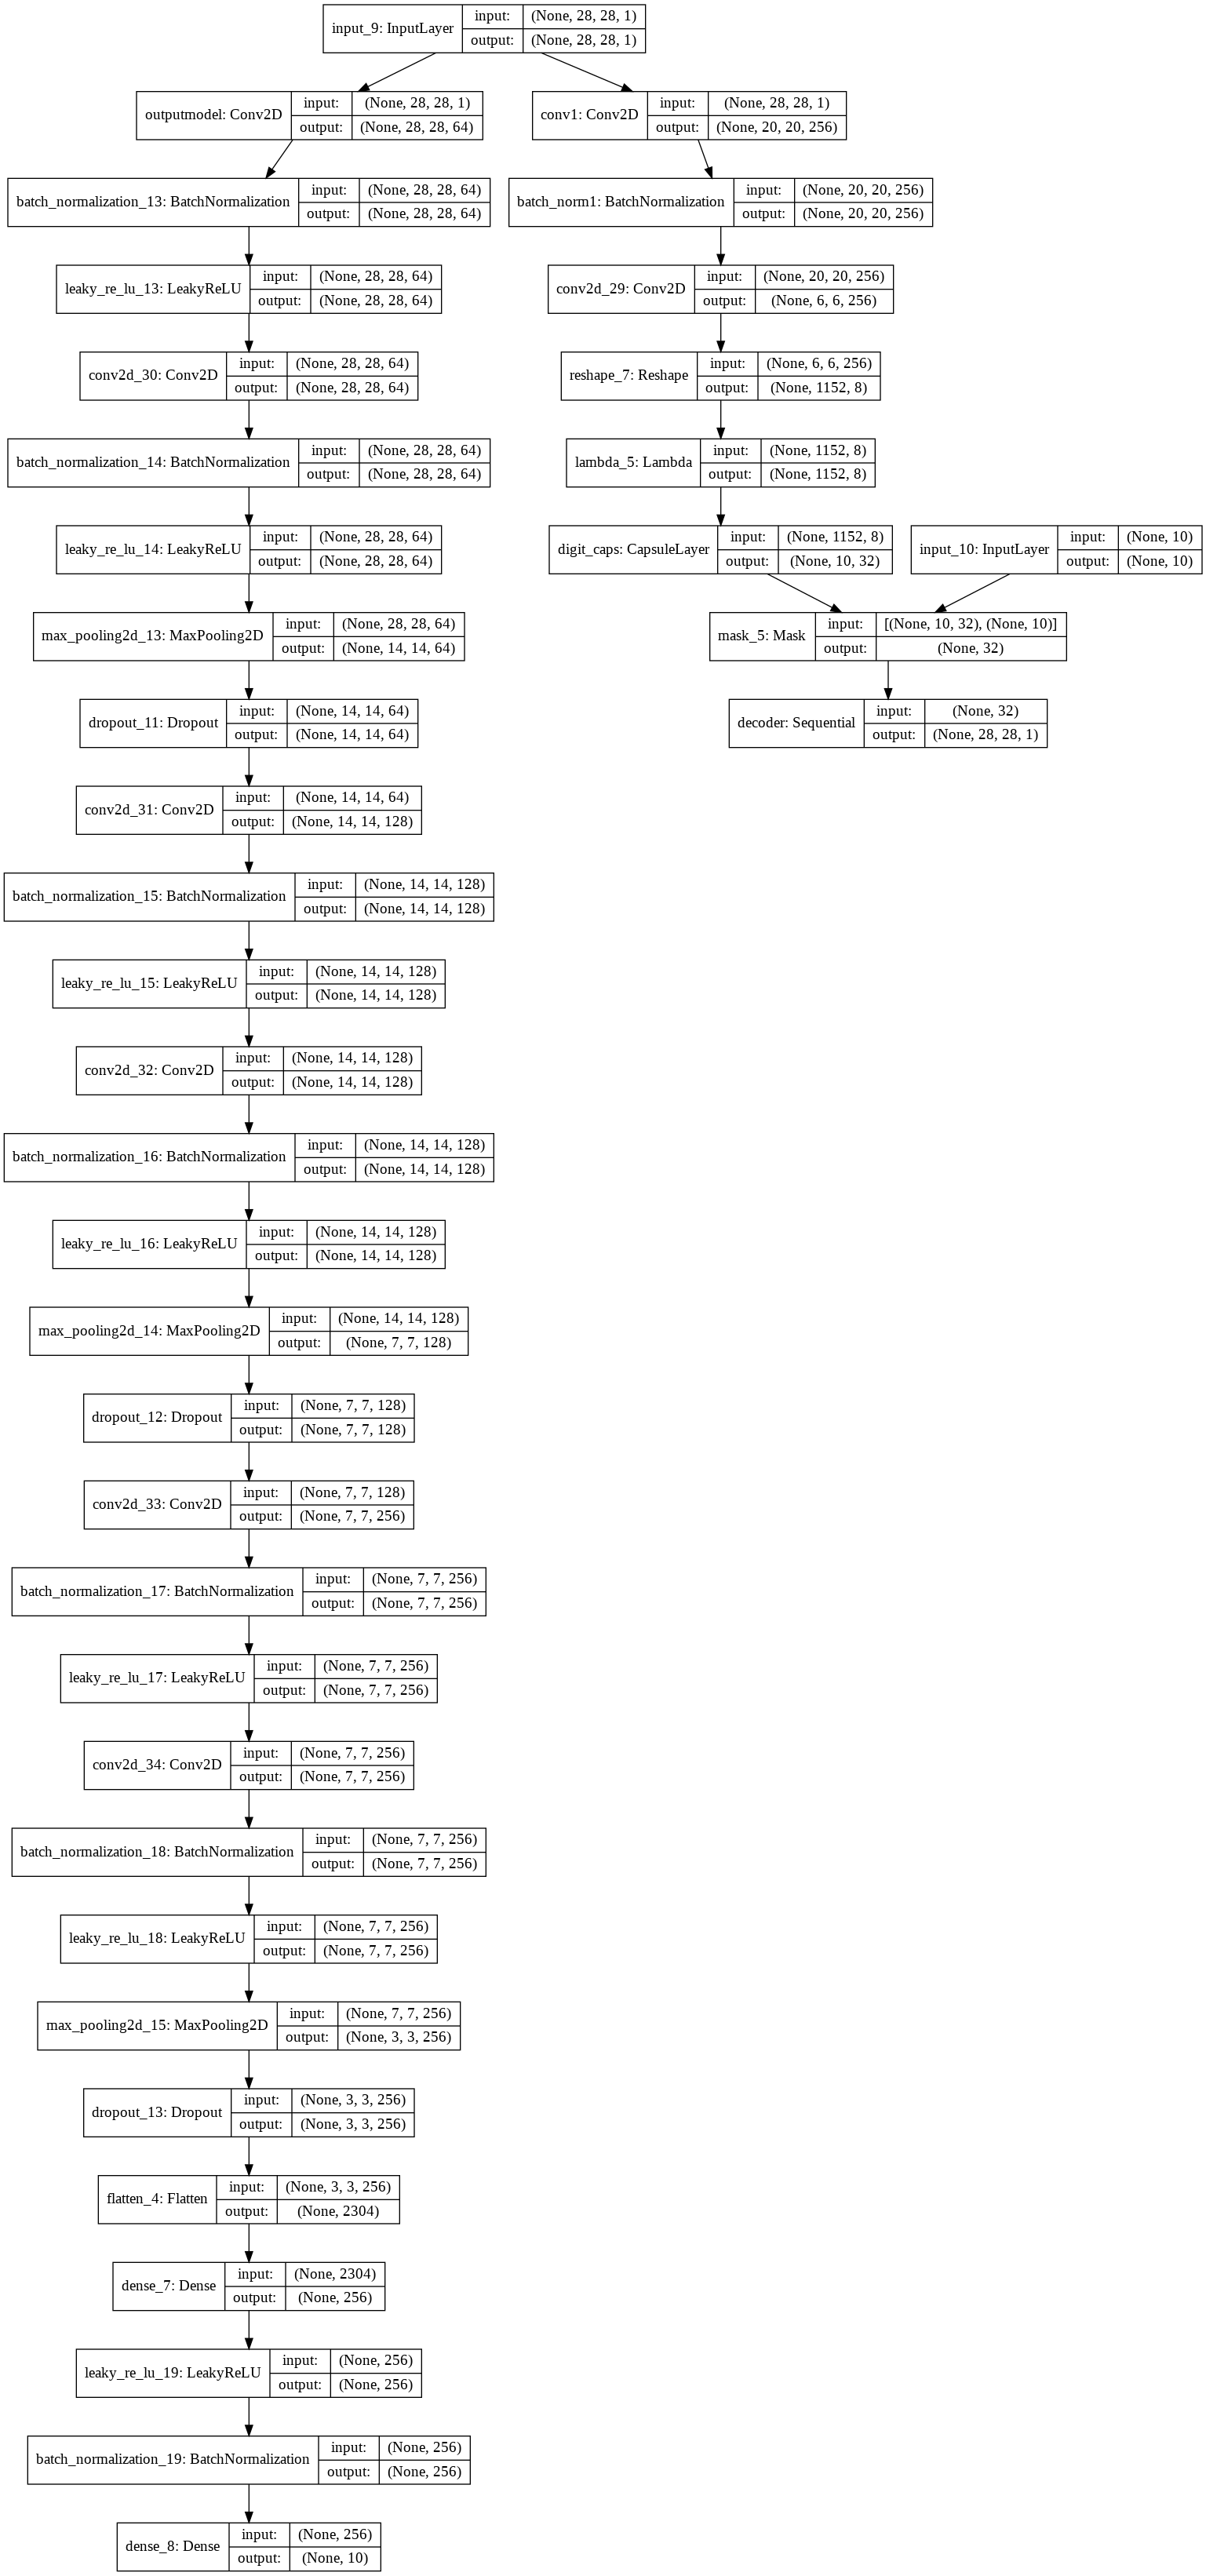

In [58]:
from IPython.display import Image
Image('model.png', width=750, height=750)

Decoder/Reconstruction network

In [59]:
Image('decoder.png', width=450, height=750)

In [60]:
pd.set_option('display.max_columns', None)

df = pd.read_csv('log.csv')
print(df.columns)

Index(['epoch', 'decoder_loss', 'dense_8_loss', 'loss', 'lr',
       'val_decoder_loss', 'val_dense_8_loss', 'val_loss'],
      dtype='object')


**Filter the values to visualise**

In [66]:
# loss
loss = df['loss'].to_list()
val_loss = df['val_loss'].to_list()

# Break-down the losses into components
#out_caps_loss = df['out_caps_loss'].to_list()
#val_out_caps_loss = df['val_out_caps_loss'].to_list()

decoder_loss = df['decoder_loss'].to_list()
val_decoder_loss = df['val_decoder_loss'].to_list()

# accuracy
#out_caps_acc = df['out_caps_acc'].to_list()
#val_out_caps_acc = df['val_out_caps_acc'].to_list()

**Configure plotting tool(here: matplotlib)**

In [62]:
from pylab import rcParams
rcParams['figure.figsize'] = 5, 10
plt.style.use('fivethirtyeight')
plt.rc('grid', color='k', linestyle='--')
plt.rc('xtick', direction='out', color='black')
plt.rc('ytick', direction='out', color='black')
plt.rc('axes', facecolor='#E6E6E6', edgecolor='gray', axisbelow=True, grid=True)

**Plot the loss and accuracy values**

Text(0.5, 1.0, 'Training and Validation Reconstruction Loss')

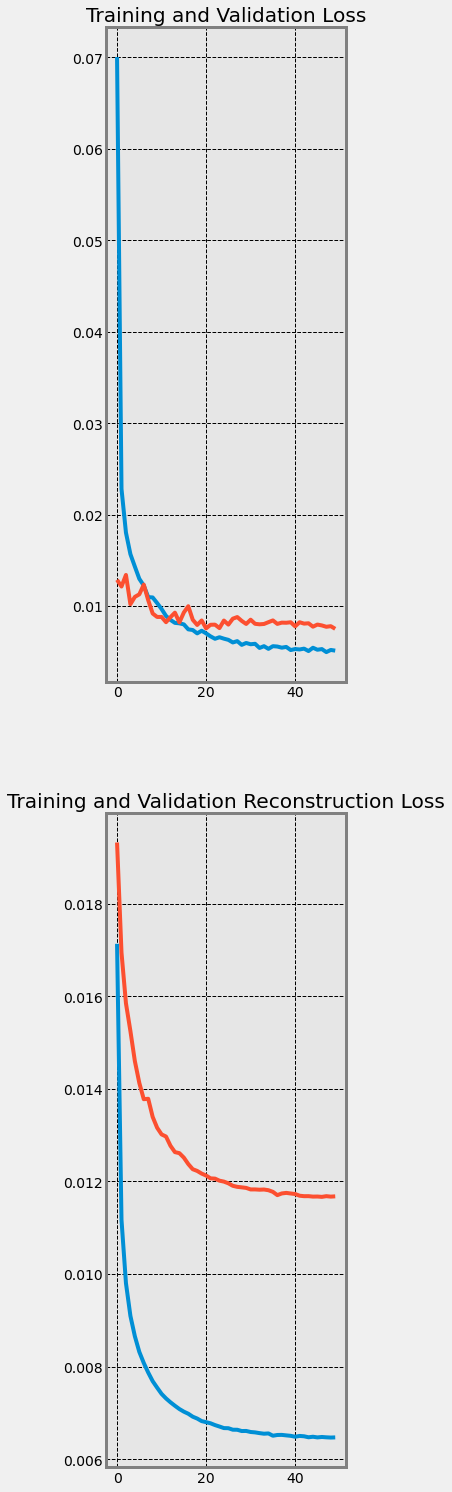

In [67]:
epochs = range(len(loss))

params = {'left' : 1,
          'right' : 3,
          'bottom' : 1,
          'top' : 3, 
          'wspace' : 1,          
          'hspace' : 0.2}
              
plt.subplots_adjust(**params)

# Plot retrieved data : accuracy
'''plt.subplot(221)
plt.plot(epochs, out_caps_acc)
plt.plot(epochs, val_out_caps_acc)
plt.title("Training and Validation Accuracy")'''

# Plot retrieved data : loss
plt.subplot(222)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validation Loss")

# Plot retrieved data : capsule loss
'''plt.subplot(223)
plt.plot(epochs, out_caps_loss)
plt.plot(epochs, val_out_caps_loss)
plt.title("Training and Validation Capsule Loss")'''

# Plot retrieved data : reconstruction loss
plt.subplot(224)
plt.plot(epochs, decoder_loss)
plt.plot(epochs, val_decoder_loss)
plt.title("Training and Validation Reconstruction Loss")

**Reconstruction**

Pick out 1 random image from each of test and dig sets and compare their reconstructions with the original image

For the sample number 2394 in the test set


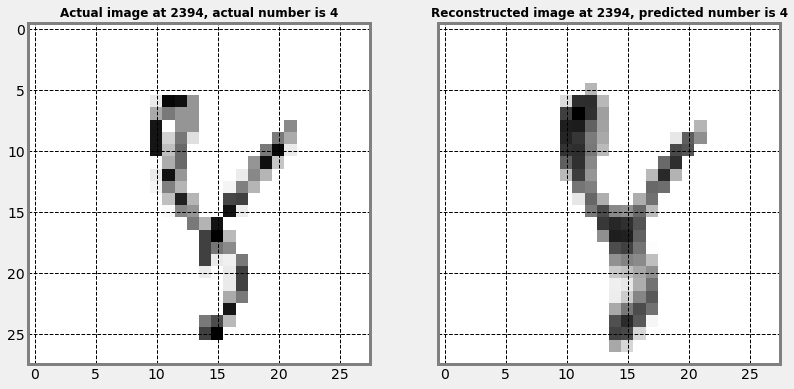

In [68]:
import random
index = random.randint(1, 10000)

print(f'For the sample number {index} in the test set')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 12))
ax1.set_title(f'Actual image at {index}, actual number is {np.argmax(y_test[index])}', fontsize=12, fontweight='bold')
ax1.imshow(x_test[index].reshape(28, 28), cmap=plt.cm.binary)
ax2.set_title(f'Reconstructed image at {index}, predicted number is {np.argmax(y_pred[index])}', fontsize=12, fontweight='bold')
ax2.imshow(x_recon[index].reshape(28, 28), cmap=plt.cm.binary)

For the sample number 4604 in the DIG set


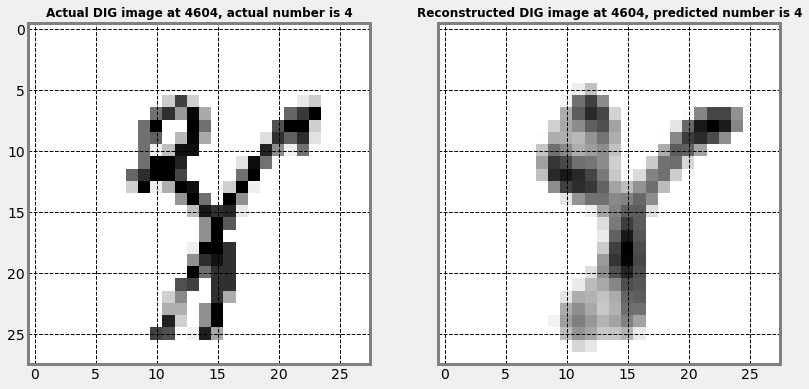

In [69]:
index = random.randint(1, 10000)

print(f'For the sample number {index} in the DIG set')
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 12))
ax1.set_title(f'Actual DIG image at {index}, actual number is {np.argmax(y_dig[index])}', fontsize=12, fontweight='bold')
ax1.imshow(x_dig[index].reshape(28, 28), cmap=plt.cm.binary)
ax2.set_title(f'Reconstructed DIG image at {index}, predicted number is {np.argmax(dig_pred[index])}', fontsize=12, fontweight='bold')
ax2.imshow(dig_recon[index].reshape(28, 28), cmap=plt.cm.binary)

**Plot the confusion matrix and calculate a digit-by-digit accuracy of the model's predictions**

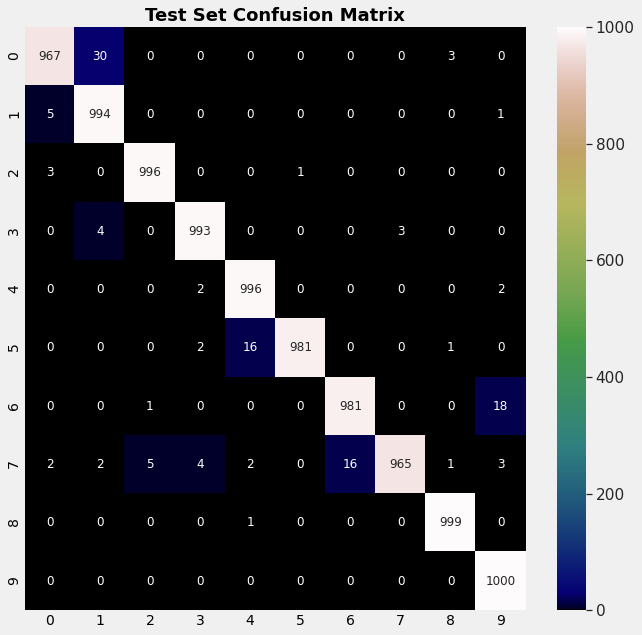

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

labels = []
preds = []
for i in range(y_test.shape[0]):
  labels.append(np.argmax(y_test[i]))
  preds.append(np.argmax(y_pred[i]))

plt.figure(figsize=(10, 10))
plt.title("Test Set Confusion Matrix", fontsize=18, fontweight="bold")
cm = confusion_matrix(labels, preds)
sn.set(font_scale=1.4) # for label size
sn.heatmap(cm, annot=True, fmt='g', cmap="gist_earth", annot_kws={"size": 12}) # flag_r, copper, gist_earth, icefire

plt.show()

In [71]:
print("For the Kannada MNIST test set:")
num = 0
for row in cm:
  print(f'Classification accuracy for the number {num} is {round((max(row)/sum(row)*100), 2)}%')
  num += 1

For the Kannada MNIST test set:
Classification accuracy for the number 0 is 96.7%
Classification accuracy for the number 1 is 99.4%
Classification accuracy for the number 2 is 99.6%
Classification accuracy for the number 3 is 99.3%
Classification accuracy for the number 4 is 99.6%
Classification accuracy for the number 5 is 98.1%
Classification accuracy for the number 6 is 98.1%
Classification accuracy for the number 7 is 96.5%
Classification accuracy for the number 8 is 99.9%
Classification accuracy for the number 9 is 100.0%


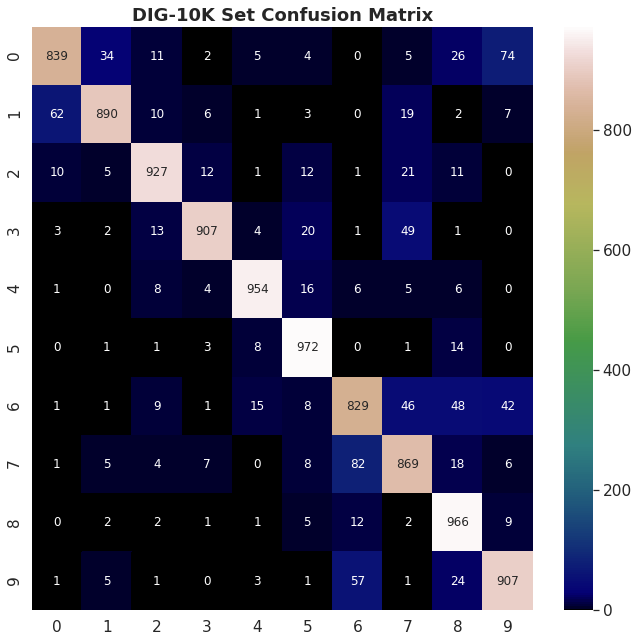

In [72]:
dig_labels = []
dig_preds = []
for i in range(y_dig.shape[0]):
  dig_labels.append(np.argmax(y_dig[i]))
  dig_preds.append(np.argmax(dig_pred[i]))

plt.figure(figsize=(10, 10))
plt.title("DIG-10K Set Confusion Matrix", fontsize=18, fontweight="bold")
dig_cm = confusion_matrix(dig_labels, dig_preds)
sn.set(font_scale=1.4) # for label size
sn.heatmap(dig_cm, annot=True, fmt='g', cmap="gist_earth", annot_kws={"size": 12}) # flag_r, copper, gist_earth, icefire

plt.show()

In [73]:
print("For the DIG-10K set:")
num = 0
for row in dig_cm:
  print(f'Classification accuracy for the number {num} is {round((max(row)/sum(row)*100), 2)}%')
  num += 1

For the DIG-10K set:
Classification accuracy for the number 0 is 83.9%
Classification accuracy for the number 1 is 89.0%
Classification accuracy for the number 2 is 92.7%
Classification accuracy for the number 3 is 90.7%
Classification accuracy for the number 4 is 95.4%
Classification accuracy for the number 5 is 97.2%
Classification accuracy for the number 6 is 82.9%
Classification accuracy for the number 7 is 86.9%
Classification accuracy for the number 8 is 96.6%
Classification accuracy for the number 9 is 90.7%


# Digit manipulation

**Manipulate the each of the digit caps dimensions independently and visualise its effect on the input image.**

Utility function to stack rows of manipulated digit images

In [ ]:
import math
def combine_images(generated_images, height=None, width=None):
    num = generated_images.shape[0]
    if width is None and height is None: # both height and width not given
        width = int(math.sqrt(num))
        height = int(math.ceil(float(num)/width))
    elif width is not None and height is None:  # height not given
        height = int(math.ceil(float(num)/width))
    elif height is not None and width is None:  # width not given
        width = int(math.ceil(float(num)/height))

    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                    dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = img[:, :, 0]
    return image

Utility function to manipulate digit caps output vector dimensions and visualise their effects on the reconstructed images

In [ ]:
from PIL import Image
def manipulate_latent(model, data, digit):
    x_test, y_test = data
    result = np.argmax(y_test, 1) == digit # bool array
    index = np.random.randint(low=0, high=sum(result) - 1) # select
    x, y = x_test[result][index], y_test[result][index]
    x, y = np.expand_dims(x, 0), np.expand_dims(y, 0)
    noise = np.zeros([1, num_classes, args.digit_caps_dim_vector]) # init the noise matrix
    x_recons = []
    for dim in range(args.digit_caps_dim_vector):
      # there are digit_caps_dim_vector dimensions to be tweaked, each such dimension will see the 11 distortions given below
        for r in [-0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25]:
            tmp = np.copy(noise)
            tmp[:,:,dim] = r
            x_recon = model.predict([x, y, tmp])
            x_recons.append(x_recon)

    x_recons = np.concatenate(x_recons)
    img = combine_images(x_recons, height=args.digit_caps_dim_vector)
    image = img*255
    Image.fromarray(image.astype(np.uint8)).save('manipulate/manipulate-%d.png' %digit)
    print('Result saved to manipulate/manipulate-%d.png' % (digit))

Create the manipulate directory if it does not already exist

In [ ]:
!pwd

In [ ]:
%%bash
if [ -s "manipulate" ]; then 
echo "directory named manipulate exists at $(pwd manipulate)" || exit
else
mkdir -p manipulate && echo "created directory manipulate at $(pwd manipulate)" || exit
fi

In [ ]:
for digit in range(10):
  manipulate_latent(manip_model, (x_test, y_test), digit)

Download the results to local machine

In [ ]:
!zip -r /content/manipulated_images.zip /content/manipulate

In [ ]:
from google.colab import files
files.download("/content/manipulated_images.zip")